In [1]:
# Authors:
# Freese, Julius <jufr23ac@student.cbs.dk>
# Haunberger, Vincent <viha23al@student.cbs.dk>
# Schröder, Fynn <fysc23ab@student.cbs.dk>

In [2]:
"""This notebook contains the code for the 2 Tower Recommendation Model. Each model
version is tested against the validation set. The best model is then evaluated on the 
common test set using the common evaluation metrics.

Sections:
(1) Data Setup
(2) Model Building
(3) Hyperparameter Tuning
(4) Model Evaluation
"""

'This notebook contains the code for the 2 Tower Recommendation Model. Each model\nversion is tested against the validation set. The best model is then evaluated on the \ncommon test set using the common evaluation metrics.\n\nSections:\n(1) Data Setup\n(2) Model Building\n(3) Hyperparameter Tuning\n(4) Model Evaluation\n'

## (1) Data Setup

In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report

from common.training_data import (
    create_negative_samples,
    create_item_df,
    create_user_df,
    create_label_df
)
from common.data_loaders import (
    load_test_resp_eval_frame
)

from common.model_evaluation import (
    calculate_global_metrics,
    evaluate_recommendation
)

In [4]:
development_lookup = pd.read_csv('data/mappings/eid_lookup_dev.csv').drop(['Unnamed: 0', 'eid.1'], axis=1, errors='ignore')
development_lookup

,eid,uid,cid,Date
0,143120_2956_2024-05-03,143120,2956,2024-05-03
1,501660_5560_2024-03-05,501660,5560,2024-03-05
2,463932_4154_2024-01-03,463932,4154,2024-01-03
3,471884_2908_2024-01-15,471884,2908,2024-01-15
4,155969_1304_2024-03-22,155969,1304,2024-03-22
...,...,...,...,...
703294,460787_3920_2024-02-24,460787,3920,2024-02-24
703295,186537_2114_2024-02-07,186537,2114,2024-02-07
703296,262804_5576_2024-02-03,262804,5576,2024-02-03
703297,478021_3677_2024-02-17,478021,3677,2024-02-17


In [5]:
interactions = pd.read_csv('data/processed/interactions.csv').drop('Unnamed: 0', axis=1, errors='ignore')
item_embeddings = pd.read_csv('data/embeddings/oai_embeddings_df.csv').drop('Unnamed: 0', axis=1, errors='ignore')
user_embeddings = pd.read_csv('data/processed/user_embeddings.csv').drop('Unnamed: 0', axis=1, errors='ignore')
development_lookup = pd.read_csv('data/mappings/eid_lookup_dev.csv').drop(['Unnamed: 0', 'eid.1'], axis=1, errors='ignore')
test_lookup = load_test_resp_eval_frame()[['eid', 'uid', 'cid', 'Date']]

loading responses data ...


In [6]:
# eid lookup: this is the mapping for the training data. Item embeddings are indexed by
# the cid, users are indexed by the uid. The eid is the unique identifier for this
# interaction. Additionally, negative samples are added in this step.

eid_lookup = development_lookup.copy()
eid_lookup = eid_lookup.merge(interactions, on='eid', how='left')
eid_lookup = eid_lookup.rename(columns={'uid_x': 'uid', 'cid_x': 'cid', 'Date_x': 'Date'})
eid_lookup = eid_lookup.drop(['uid_y', 'cid_y', 'Date_y'], axis=1, errors='ignore')
eid_lookup = eid_lookup[['eid', 'uid', 'cid', 'Date']]
print(eid_lookup.shape)
eid_lookup.head(3)

(703299, 4)


,eid,uid,cid,Date
0,143120_2956_2024-05-03,143120,2956,2024-05-03
1,501660_5560_2024-03-05,501660,5560,2024-03-05
2,463932_4154_2024-01-03,463932,4154,2024-01-03


In [7]:
# test lookp: this is the mapping for the test data.
test_lookup.tail(3)

,eid,uid,cid,Date
49997,536680_5891_2024-02-29,536680,5891,2024-02-29
49998,536691_4085_2024-01-15,536691,4085,2024-01-15
49999,536698_1924_2024-01-14,536698,1924,2024-01-14


In [8]:
# Create training set and validation set from development set, the test set is provided
# seperately.

# for running this locally, reduce the number of samples
n_train = 80_100
n_val = 20_100
neg_sample_ratio = 1 # todo: make sure that negatives in test are not in train

eid_lookup_train = eid_lookup.sample(n=n_train, random_state=42)
eid_lookup_eval = eid_lookup[~eid_lookup.eid.isin(eid_lookup_train.eid)].sample(n=n_val, random_state=42)

eid_lookup_train = create_negative_samples(eid_lookup_train, item_embeddings, neg_sample_ratio)
eid_lookup_eval = create_negative_samples(eid_lookup_eval, item_embeddings, neg_sample_ratio)
# note: no negative samples for test set, due to comparability to other models

# Shuffle the data
eid_lookup_test = test_lookup.sample(frac=1)
eid_lookup_test["label"] = 1
eid_lookup_test.drop("Date", axis=1, inplace=True)
eid_lookup_train = eid_lookup_train.sample(frac=1)
eid_lookup_eval = eid_lookup_eval.sample(frac=1)

Sampling negative samples ...
Sampling negative samples ...


In [9]:
print(eid_lookup_train.shape)
print(eid_lookup_train.value_counts('label'))

(160200, 4)
label
0    80100
1    80100
Name: count, dtype: int64


In [10]:
df_users_train = create_user_df(df_users=user_embeddings, eid_scope=eid_lookup_train)
df_users_test = create_user_df(df_users=user_embeddings, eid_scope=eid_lookup_test)
df_users_eval = create_user_df(df_users=user_embeddings, eid_scope=eid_lookup_eval)
df_users_train.head(2)

df_users shape:  (160200, 90)
df_users shape:  (50000, 90)
df_users shape:  (40200, 90)


,Region_Bavaria,Region_Capital Region of Denmark,Region_Castile-La Mancha,Region_Central Denmark Region,Region_Emilia-Romagna,Region_England,Region_Halland County,Region_Hauts-de-France,Region_Hessen,Region_Ile-de-France,...,PageReferrerDomain_other,PageReferrerDomain_unknown,PageReferrerDomain_www.aeldresagen,PageReferrerDomain_www.bing,PageReferrerDomain_www.bravotours,PageReferrerDomain_www.ecosia,PageReferrerDomain_www.google,PageReferrerDomain_www.puregym,PageReferrerDomain_www.spies,PageReferrerDomain_www.startpage
eid,,,,,,,,,,,,,,,,,,,,,
279609_346_nad,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
84350_6382_nad,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [11]:
df_items_train = create_item_df(df_items=item_embeddings, eid_scope=eid_lookup_train)
df_items_test = create_item_df(df_items=item_embeddings, eid_scope=eid_lookup_test)
df_items_eval = create_item_df(df_items=item_embeddings, eid_scope=eid_lookup_eval)
df_items_train.head(2)

df_items shape:  (160200, 1536)
df_items shape:  (50000, 1536)
df_items shape:  (40200, 1536)


,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
eid,,,,,,,,,,,,,,,,,,,,,
279609_346_nad,-0.000939,-0.003870,-0.008608,-0.016582,0.009730,0.034321,-0.040767,-0.000530,-0.001538,-0.026843,...,0.004366,0.010109,0.005278,-0.018221,-0.032475,0.006986,-0.009964,-0.022766,-0.008484,-0.023592
84350_6382_nad,-0.017811,-0.002189,-0.010909,-0.003185,0.001434,0.010287,-0.012310,-0.042937,0.008750,-0.015774,...,-0.010034,-0.020275,0.040032,-0.011331,-0.020574,0.009191,-0.002131,-0.015398,-0.003804,-0.010183


In [12]:
df_labels_train = create_label_df(df_labels=interactions, eid_scope=eid_lookup_train, target_col='click')
df_labels_test = create_label_df(df_labels=interactions, eid_scope=eid_lookup_test, target_col='click')
df_labels_eval = create_label_df(df_labels=interactions, eid_scope=eid_lookup_eval, target_col='click')
df_labels_train.head(2)

df_labels shape:  (160200, 1)
df_labels shape:  (50000, 1)
df_labels shape:  (40200, 1)


,label
eid,
279609_346_nad,0
84350_6382_nad,0


In [13]:
# check if input frames have same size
assert df_users_train.shape[0] == df_items_train.shape[0] == df_labels_train.shape[0]

In [14]:
user_features_train = df_users_train.to_numpy()
item_features_train = df_items_train.to_numpy()
labels_train = df_labels_train.to_numpy()
print("TRAIN DATA shapes: ", (user_features_train.shape, item_features_train.shape, labels_train.shape))

user_features_test = df_users_test.to_numpy()
item_features_test = df_items_test.to_numpy()
labels_test = df_labels_test.to_numpy()
print("TEST DATA shapes:  ", (user_features_test.shape, item_features_test.shape, labels_test.shape))

user_features_eval = df_users_eval.to_numpy()
item_features_eval = df_items_eval.to_numpy()
labels_eval = df_labels_eval.to_numpy()
print("EVAL DATA shapes:  ", (user_features_eval.shape, item_features_eval.shape, labels_eval.shape))

TRAIN DATA shapes:  ((160200, 90), (160200, 1536), (160200, 1))
TEST DATA shapes:   ((50000, 90), (50000, 1536), (50000, 1))
EVAL DATA shapes:   ((40200, 90), (40200, 1536), (40200, 1))


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from joblib import Parallel, delayed
from multiprocessing import Pool, cpu_count

from tensorflow.keras.layers import (
    Input,
    Dense,
    Dot,
    Flatten,
    Concatenate,
    Dropout,
    Embedding
)

from common.tt_recommender import BaseTTRecommender

## (2) Model Building

In [16]:
class TTM_1(BaseTTRecommender):
    """This class implements the 2 Tower Model in a basic version. The model consists of
    a user tower and an item tower. Both towers are connected by a dot product layer. The
    intput are user embeddings and item embeddings. The output is a binary classification.
    """
    
    def build_model(self, users_input_dim: int = 90, items_input_dim: int = 1536):
        
        # -----  USER TOWER  ----- #
        user_input = Input(shape=(users_input_dim,))
        # user_dense_1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(user_input)
        # user_dense_1 = Dropout(0.2)(user_dense_1)
        user_dense_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(user_input)
        user_dense_2 = Dropout(0.2)(user_dense_2)
        user_final_layer = Dense(32, activation='relu')(user_dense_2)

        # -----  ITEM TOWER  ----- #
        item_input = Input(shape=(items_input_dim,))
        item_dense_1 = Dense(512, activation='relu')(item_input)
        #item_dense_2 = Dense(256, activation='relu')(item_dense_1)
        item_dense_1 = Dropout(0.2)(item_dense_1)
        item_dense_3 = Dense(128, activation='relu')(item_dense_1)
        #item_dense_4 = Dense(64, activation='relu')(item_dense_3)
        item_final_layer = Dense(32, activation='relu')(item_dense_3)

        # -----  TOWER COMBINATION  ----- #
        combined = Dot(axes=1)([user_final_layer, item_final_layer])
        combined_dense_1 = Dense(64, activation='relu')(combined)
        combined_dense_2 = Dense(32, activation='relu')(combined_dense_1)
        combined_dense_3 = Dense(16, activation='relu')(combined_dense_2)
        # Output layer (for binary classification)
        output = Dense(1, activation='sigmoid')(combined_dense_3)

        optimizer = Adam(learning_rate=0.01)
        model = Model(inputs=[user_input, item_input], outputs=output)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

Epoch 1/12
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8147 - loss: 0.5132 - val_accuracy: 0.8674 - val_loss: 0.3167
Epoch 2/12
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8716 - loss: 0.3079 - val_accuracy: 0.8771 - val_loss: 0.2988
Epoch 3/12
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8768 - loss: 0.3003 - val_accuracy: 0.8771 - val_loss: 0.2960
Epoch 4/12
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8794 - loss: 0.2954 - val_accuracy: 0.8804 - val_loss: 0.2969
Epoch 5/12
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8814 - loss: 0.2911 - val_accuracy: 0.8802 - val_loss: 0.2914
Epoch 6/12
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8833 - loss: 0.2875 - val_accuracy: 0.8813 - val_loss: 0.2912
Epoch 7/12
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8822 - loss: 0.2887 - val_accuracy: 0.8824 - val_loss: 0.2888
Epoch 8/12
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8834 - loss: 0.2874 - val_accu

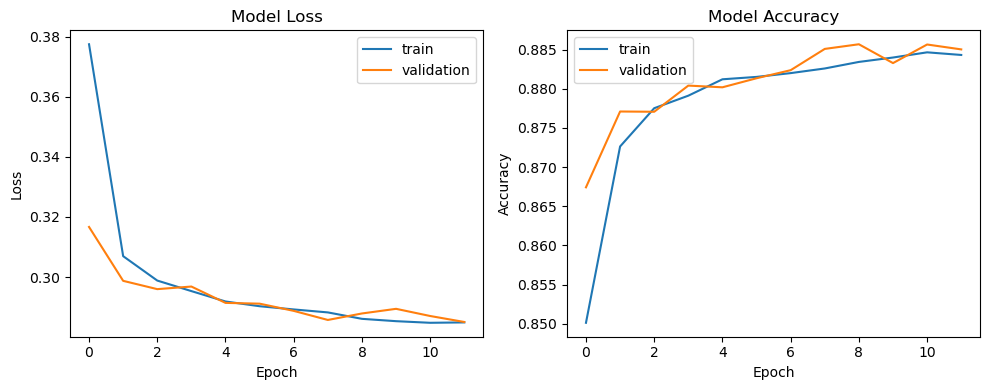

In [17]:
ttm1 = TTM_1()

ttm1_history = ttm1.fit(
    [user_features_train, item_features_train],
    labels_train,
    epochs=12,
    batch_size=500,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

ttm1.plot_model_history()

In [18]:
# In Sample Training Classification Report
predictions = ttm1.model.predict([user_features_train, item_features_train])
predictions_flat = np.round(predictions).flatten()
print(classification_report(labels_train, predictions_flat))

5007/5007 ━━━━━━━━━━━━━━━━━━━━ 5s 947us/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     80100
           1       0.91      0.86      0.88     80100

    accuracy                           0.89    160200
   macro avg       0.89      0.89      0.89    160200
weighted avg       0.89      0.89      0.89    160200



In [19]:
class TTM_2(BaseTTRecommender):
    """This is the second version of the 2-Tower Model. It incorporates user and item IDs
    to learn interactions similar to a collaborative filtering approach. The input are
    user and item embeddings as well as user and item IDs. The output is a binary
    classification.
    """

    def build_model(self, num_users: int, num_items: int, embedding_dim: int = 32,
                    users_input_dim: int = 90, items_input_dim: int = 1536):
        
        # -----  USER TOWER  ----- #
        # id embedding
        user_id_input = Input(shape=(1,), name='user_id_input')
        user_id_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_id_input)
        user_id_embedding = Flatten()(user_id_embedding)
        # setup user input
        user_input = Input(shape=(users_input_dim,), name='user_input')
        user_combined = Concatenate()([user_input, user_id_embedding])

        # deep user layers
        user_dense_1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(user_combined)
        user_dense_1 = Dropout(0.2)(user_dense_1)
        user_dense_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(user_combined)
        user_dense_2 = Dropout(0.2)(user_dense_2)
        user_final_layer = Dense(32)(user_dense_2)

        # -----  ITEM TOWER  ----- #
        # id embedding
        item_id_input = Input(shape=(1,), name='item_id_input')
        item_id_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding')(item_id_input)
        item_id_embedding = Flatten()(item_id_embedding)
        # setup item input
        item_input = Input(shape=(items_input_dim,), name='item_input')
        item_combined = Concatenate()([item_input, item_id_embedding])

        # deep item layers
        item_dense_1 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(item_combined)
        item_dense_1 = Dropout(0.2)(item_dense_1)
        item_dense_2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(item_combined)
        item_dense_2 = Dropout(0.2)(item_dense_2)
        item_final_layer = Dense(32)(item_dense_2)


        # -----  TOWER COMBINATION  ----- #
        combined = Concatenate()([user_final_layer, item_final_layer])
        combined_dense_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
        combined_dense_1 = Dropout(0.2)(combined_dense_1)
        combined_dense_2 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(combined_dense_1)
        combined_dense_2 = Dropout(0.2)(combined_dense_2)
        combined_dense_3 = Dense(16)(combined_dense_2)
        output = Dense(1, activation='sigmoid')(combined_dense_3)

        optimizer = Adam(learning_rate=0.01)
        model = Model(inputs=[user_id_input, item_id_input, user_input, item_input], outputs=output)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

Epoch 1/8
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8059 - loss: 0.8193 - val_accuracy: 0.8829 - val_loss: 0.3158
Epoch 2/8
257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8792 - loss: 0.3195 - val_accuracy: 0.8843 - val_loss: 0.3116
Epoch 3/8
257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8851 - loss: 0.2968 - val_accuracy: 0.8839 - val_loss: 0.3155
Epoch 4/8
257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8893 - loss: 0.2892 - val_accuracy: 0.8867 - val_loss: 0.3306
Epoch 5/8
257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8888 - loss: 0.2884 - val_accuracy: 0.8774 - val_loss: 0.3324
Epoch 6/8
257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8891 - loss: 0.2858 - val_accuracy: 0.8869 - val_loss: 0.3551
Epoch 7/8
257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8898 - loss: 0.2839 - val_accuracy: 0.8867 - val_loss: 0.3457


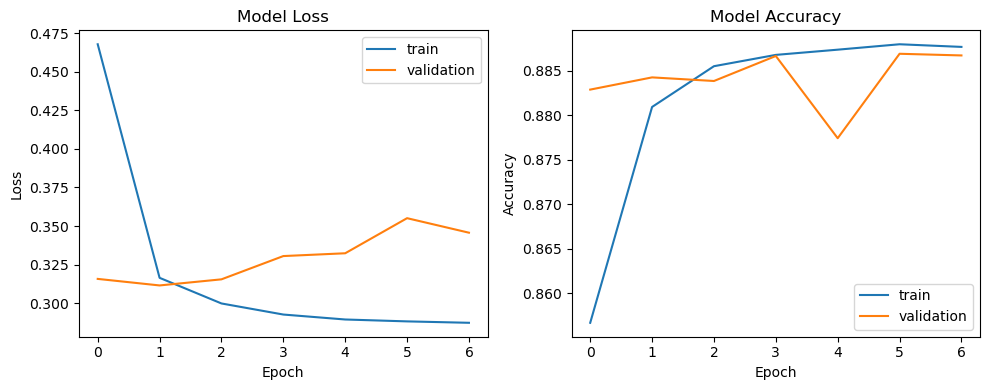

In [20]:
uids_train = eid_lookup_train["uid"].values
cids_train = eid_lookup_train["cid"].values
labels_train = eid_lookup_train["label"].values


ttm2 = TTM_2(num_users=536699, num_items=6648)

ttm2_history = ttm2.fit(
    [uids_train, cids_train, user_features_train, item_features_train],
    labels_train,
    epochs=8,
    batch_size=500,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

ttm2.plot_model_history()

## (3) Hyperparameter Tuning

In [21]:
import json
import keras_tuner as kt
import tensorflow.keras as keras

In [22]:
class TTMHyperModel(kt.HyperModel):
    def __init__(self, num_users, num_items, users_input_dim, items_input_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.users_input_dim = users_input_dim
        self.items_input_dim = items_input_dim

    def build(self, hp):
        embedding_dim = hp.Int('embedding_dim', min_value=16, max_value=64, step=16)
        user_dense_units = hp.Int('user_dense_units', min_value=64, max_value=256, step=64)
        item_dense_units = hp.Int('item_dense_units', min_value=128, max_value=512, step=128)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        l2_reg = hp.Float('l2_reg', min_value=0.01, max_value=0.1, step=0.01)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

        # User tower
        user_id_input = Input(shape=(1,), name='user_id_input')
        user_id_embedding = Embedding(input_dim=self.num_users, output_dim=embedding_dim, name='user_embedding')(user_id_input)
        user_id_embedding = Flatten()(user_id_embedding)
        
        user_input = Input(shape=(self.users_input_dim,), name='user_input')
        user_combined = Dense(embedding_dim)(user_input)

        user_dense = Dense(user_dense_units, activation='relu', kernel_regularizer=l2(l2_reg))(user_combined)
        user_dense = Dropout(dropout_rate)(user_dense)
        user_final_layer = Dense(embedding_dim)(user_dense)

        # Item tower
        item_id_input = Input(shape=(1,), name='item_id_input')
        item_id_embedding = Embedding(input_dim=self.num_items, output_dim=embedding_dim, name='item_embedding')(item_id_input)
        item_id_embedding = Flatten()(item_id_embedding)
        
        item_input = Input(shape=(self.items_input_dim,), name='item_input')
        item_combined = Dense(embedding_dim)(item_input)

        item_dense = Dense(item_dense_units, activation='relu', kernel_regularizer=l2(l2_reg))(item_combined)
        item_dense = Dropout(dropout_rate)(item_dense)
        item_final_layer = Dense(embedding_dim)(item_dense) 

        # Combine towers using Dot layer
        combined = Concatenate()([user_final_layer, item_final_layer])
        combined_dense = Dense(embedding_dim, activation='relu', kernel_regularizer=l2(l2_reg))(combined)
        combined_dense = Dropout(dropout_rate)(combined_dense)
        combined_dense_final = Dense(embedding_dim // 2)(combined_dense)
        output = Dense(1, activation='sigmoid')(combined_dense_final)

        model = Model(inputs=[user_id_input, item_id_input, user_input, item_input], outputs=output)
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

        return model


class HistoryLoggingCallback(keras.callbacks.Callback):
    """Callback to save the history of each trial in a json file."""
    def on_trial_end(self, trial):
        history = trial.metrics.get_history()
        print(f"Saving history for trial {trial.trial_id}")
        with open(f'trial_{trial.trial_id}_history.json', 'w') as f:
            json.dump(history, f)

In [23]:
tuner = kt.RandomSearch(
    TTMHyperModel(num_users=536699, num_items=6648, users_input_dim=90, items_input_dim=1536),
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='tuning',
    project_name='ttm2_tuning'
)

tuner.search(
    [uids_train, cids_train, user_features_train, item_features_train],
    labels_train,
    epochs=10,
    batch_size=500,
    validation_split=0.2,
    callbacks=[
        HistoryLoggingCallback(),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

Reloading Tuner from tuning/ttm2_tuning/tuner0.json


In [31]:
# get best model
best_model = tuner.get_best_models(num_models=1)[0]
ttm_tuned = TTM_2(num_users=536699, num_items=6648)
ttm_tuned.model = best_model

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [34]:
# params of best model
best_model.get_config()

{'name': 'functional_1',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 90),
    'dtype': 'float32',
    'sparse': False,
    'name': 'user_input'},
   'registered_name': None,
   'name': 'user_input',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 1536),
    'dtype': 'float32',
    'sparse': False,
    'name': 'item_input'},
   'registered_name': None,
   'name': 'item_input',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'units': 32,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',

## (4) Model Evaluation

In [24]:
test_frame = load_test_resp_eval_frame()
test_frame.head(2)

local_run_slice = slice(1000, 1100)

test_pred_user_embeddings = pd.merge(test_frame.iloc[local_run_slice,:], user_embeddings, on='uid', how='left')
test_pred_user_embeddings = test_pred_user_embeddings.drop(['cid', 'Date', 'label', 'prev_resp', 'future_resp'], axis=1, errors='ignore')

loading responses data ...


In [25]:
t0 = time.time()
ttm1_recommendations = ttm1.recommend_batch(test_pred_user_embeddings, item_embeddings, k=200)
print("_"*80 + "\nRecommendations done.")
print(f"Took: {time.time() - t0:.2f}s")

ttm1_recs = pd.DataFrame(ttm1_recommendations).T
ttm1_recs.columns = ["recommended_ids", "scores"]
ttm1_recs["eid"] = ttm1_recs.index.values

ttm1_evaluation = evaluate_recommendation(ttm1_recs, test_frame.iloc[local_run_slice,:])
ttm1_global_metrics = calculate_global_metrics(ttm1_evaluation)
print("\n\nGlobal metrics for TTM1:")
print(ttm1_global_metrics)

#users 100, #items 6648


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


5194/5194 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
________________________________________________________________________________
Recommendations done.
Took: 18.91s


Global metrics for TTM1:
     Precision@k  Recall@k       MRR       MAP  Hit Rate  Coverage
10       0.02800  0.247788  0.132313  0.110230      0.28      0.05
20       0.01850  0.327434  0.137808  0.115725      0.37      0.10
50       0.01080  0.477876  0.141520  0.120033      0.52      0.25
100      0.00690  0.610619  0.124813  0.115090      0.62      0.50
200      0.00375  0.663717  0.124327  0.115235      0.67      1.00


In [26]:
t0 = time.time()
ttm2_recommendations = ttm2.recommend_batch(test_pred_user_embeddings, item_embeddings, use_ids=True, k=200)
print("_"*80 + "\nRecommendations done.")
print(f"Took: {time.time() - t0:.2f}s")

ttm2_recs = pd.DataFrame(ttm2_recommendations).T
ttm2_recs.columns = ["recommended_ids", "scores"]
ttm2_recs["eid"] = ttm2_recs.index.values

ttm2_evaluation = evaluate_recommendation(ttm2_recs, test_frame.iloc[local_run_slice,:])
ttm2_global_metrics = calculate_global_metrics(ttm2_evaluation)
print("\n\nGlobal metrics for TTM2:")
print(ttm2_global_metrics)

#users 100, #items 6648


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


5194/5194 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
________________________________________________________________________________
Recommendations done.
Took: 15.13s


Global metrics for TTM2:
     Precision@k  Recall@k       MRR       MAP  Hit Rate  Coverage
10       0.02700  0.238938  0.137758  0.114980      0.27      0.05
20       0.02050  0.362832  0.144104  0.122175      0.40      0.10
50       0.01100  0.486726  0.148238  0.126388      0.53      0.25
100      0.00710  0.628319  0.131759  0.121631      0.64      0.50
200      0.00375  0.663717  0.131133  0.121636      0.67      1.00


In [33]:
t0 = time.time()
ttm_tuned_recommendations = ttm_tuned.recommend_batch(test_pred_user_embeddings, item_embeddings, use_ids=True, k=200)
print("_"*80 + "\nRecommendations done.")
print(f"Took: {time.time() - t0:.2f}s")

ttm_tuned_recs = pd.DataFrame(ttm_tuned_recommendations).T
ttm_tuned_recs.columns = ["recommended_ids", "scores"]
ttm_tuned_recs["eid"] = ttm_tuned_recs.index.values

ttm_tuned_evaluation = evaluate_recommendation(ttm_tuned_recs, test_frame.iloc[local_run_slice,:])
ttm_tuned_global_metrics = calculate_global_metrics(ttm_tuned_evaluation)
print("\n\nGlobal metrics for TTM Tuned:")
print(ttm_tuned_global_metrics)

#users 100, #items 6648


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5194/5194 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
________________________________________________________________________________
Recommendations done.
Took: 14.48s


Global metrics for TTM Tuned:
     Precision@k  Recall@k       MRR       MAP  Hit Rate  Coverage
10        0.0200  0.176991  0.116500  0.096083      0.20      0.05
20        0.0150  0.265487  0.112850  0.099162      0.28      0.10
50        0.0106  0.469027  0.109777  0.100952      0.47      0.25
100       0.0065  0.575221  0.111376  0.102576      0.58      0.50
200       0.0036  0.637168  0.110904  0.102761      0.64      1.00
